In [1]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
import copy
import numpy as np
import IPython.display as display




In [2]:
def display_gif(env, timesteps, idx):
    grid_size = timesteps.grid.shape[-2:]
    fig, ax = plt.subplots(figsize=grid_size)

    animate = functools.partial(env.animate, ax, jax.tree_util.tree_map(lambda x: x[:,idx:].swapaxes(1, 0), timesteps), img_prefix=os.path.join(ROOT_DIR, 'assets'))

    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)

    # Save as GIF
    gif_path = f"/tmp/block_moving_epoch.gif"
    anim.save(gif_path, writer='pillow')
    plt.close()


    # Visualize the GIF in the notebook
    display.display(display.Image(filename=gif_path))

def plot_q_value_difference(agent, states, goals, actions, episode_length, num_envs):
    """
    Plot the absolute difference between Q1 and Q2 values over timesteps.
    
    Parameters:
    -----------
    agent : Agent
        The agent with the critic network
    states : Array
        Trajectory states with shape (episode_length, num_envs, ...)
    goals : Array
        Trajectory goals with shape (episode_length, num_envs, ...)
    actions : Array
        Trajectory actions with shape (episode_length, num_envs)
    episode_length : int
        Length of episodes
    num_envs : int
        Number of parallel environments
    """
    # Reshape trajectories to combine episode and environment dimensions
    traj_states_flat = states.reshape((states.shape[0] * states.shape[1], -1))
    traj_goals_flat = goals.reshape((goals.shape[0] * goals.shape[1], -1))
    traj_actions_flat = actions.reshape((actions.shape[0] * actions.shape[1]))
    
    # Get Q-values from critic network
    q1, q2 = agent.network.select('critic')(traj_states_flat, traj_goals_flat, traj_actions_flat)
    
    # Reshape back to (episode_length, num_envs)
    q1 = q1.reshape((episode_length, num_envs))
    q2 = q2.reshape((episode_length, num_envs))
    
    # Compute mean and standard error of absolute difference
    q_diff = jnp.mean(jnp.abs(q1 - q2), axis=1)
    q_diff_std_error = jnp.std(jnp.abs(q1 - q2), axis=1) / jnp.sqrt(q1.shape[1])
    
    # Plot
    plt.plot(q_diff, label='|q1 - q2|')
    plt.fill_between(np.arange(len(q_diff)), q_diff - q_diff_std_error, 
                     q_diff + q_diff_std_error, alpha=0.2)
    plt.xlabel('Timestep')
    plt.ylabel('Absolute Difference')
    plt.title('Distance between q1 and q2 over Timesteps')
    plt.legend()
    plt.show()


In [ ]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 50
RUN_NAME = f"DQN{CHECKPOINT}_investigation"
# MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044157/runs/dqn_1.38_3_grid_4_ep_len__filter_quarter"
MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_4_grid_4_ep_len__filter_"
EPOCHS = 51
EVAL_EVERY = 10
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"
os.makedirs(FIGURES_PATH, exist_ok=True)
# os.makedirs(GIF_PATH, exist_ok=True)


In [4]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=4,
        number_of_boxes_min=1,
        number_of_boxes_max=1,
        number_of_moving_boxes_max=1
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [5]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.agent.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    "observations": dummy_timestep.grid.reshape(1, -1),  # Add batch dimension
    "next_observations": dummy_timestep.grid.reshape(1, -1),
    "actions": jnp.ones((1,), dtype=jnp.int8)
    * (env._env.action_space - 1),  # it should be the maximal value of action space
    "rewards": jnp.ones((1,), dtype=jnp.int8),
    "masks": jnp.ones((1,), dtype=jnp.int8),
    "value_goals": dummy_timestep.grid.reshape(1, -1),
    "actor_goals": dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_4_grid_4_ep_len__filter_/params_50.pkl


In [6]:
# Create env once again with correct config and collect data
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)


# %%
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

2025-10-02 22:00:20.751069: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [7]:
jitted_flatten_batch = jax.jit(jax.vmap(flatten_batch, in_axes=(None, None, 0, 0)), static_argnums=(0, 1))
jitted_create_batch = functools.partial(
    create_batch,
    gamma=config.exp.gamma,
    use_targets=config.exp.use_targets,
    use_future_and_random_goals=config.exp.use_future_and_random_goals,
    jitted_flatten_batch=jitted_flatten_batch,
    use_discounted_mc_rewards=config.agent.use_discounted_mc_rewards,
)

In [8]:
batch_key = random.PRNGKey(0)
buffer_state, transitions = replay_buffer.sample(buffer_state)
batch = jitted_create_batch(transitions, batch_key)

In [9]:
batch.keys()

dict_keys(['observations', 'next_observations', 'actions', 'rewards', 'masks', 'value_goals', 'actor_goals'])

In [10]:
all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['value_goals'], all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = qs.transpose(1, 0)  # B x 6


2025-10-02 22:00:31.548980: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [11]:
dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
dist.probs.shape

(256, 6)

(array([  1.,   1.,   0.,   1.,   9.,  12.,  28.,  43.,  43., 118.]),
 array([1.1111573 , 1.17920947, 1.24726176, 1.31531405, 1.38336623,
        1.4514184 , 1.51947069, 1.58752298, 1.65557516, 1.72362733,
        1.79167962]),
 <BarContainer object of 10 artists>)

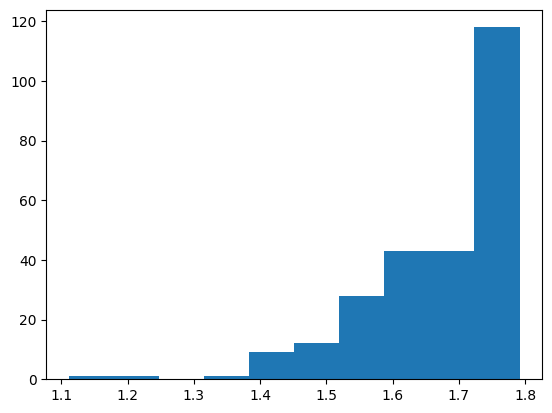

In [12]:
plt.hist(dist.entropy())

In [13]:
use_targets = False

timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=remove_targets(timesteps.grid),
        goal=remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

In [14]:
tr_states.shape

(100, 1024, 4, 4)

In [15]:
idx = 0
traj_states, traj_goals, traj_actions = tr_states[:,idx], tr_goals[:,idx], tr_actions[:,idx]
traj_states.shape

(100, 4, 4)

In [16]:
traj_states, traj_goals, traj_actions = traj_states.reshape(traj_states.shape[0], -1), traj_goals.reshape(traj_goals.shape[0], -1), traj_actions.reshape(traj_actions.shape[0])
traj_states.shape

(100, 16)

2025-10-02 22:00:37.390808: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


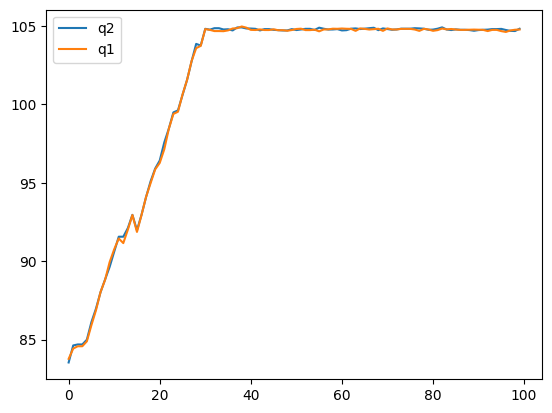

In [17]:
q1, q2 = agent.network.select('critic')(traj_states, traj_goals, traj_actions)

plt.plot(q2, label='q2')
plt.plot(q1, label='q1')
plt.legend()
plt.show()

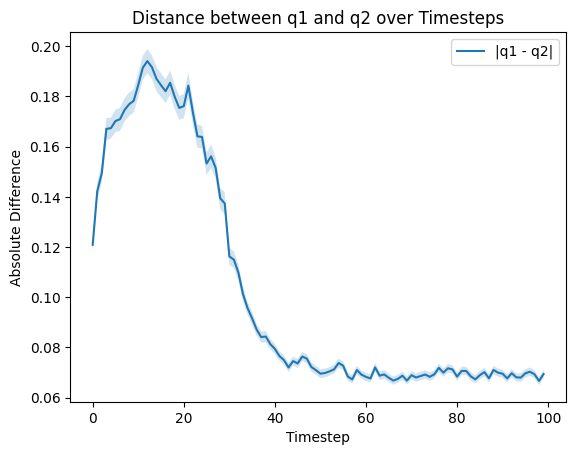

In [18]:
# Use the function
plot_q_value_difference(agent, tr_states, tr_goals, tr_actions, EPISODE_LENGTH, NUM_ENVS)

# Diagonal setup

In [19]:
config.env.generator_special=True

In [20]:
# Create env once again with correct config and collect data
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)


# %%
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

In [21]:
jitted_flatten_batch = jax.jit(jax.vmap(flatten_batch, in_axes=(None, None, 0, 0)), static_argnums=(0, 1))
jitted_create_batch = functools.partial(
    create_batch,
    gamma=config.exp.gamma,
    use_targets=config.exp.use_targets,
    use_future_and_random_goals=config.exp.use_future_and_random_goals,
    jitted_flatten_batch=jitted_flatten_batch,
    use_discounted_mc_rewards=config.agent.use_discounted_mc_rewards,
)

In [22]:
batch_key = random.PRNGKey(0)
buffer_state, transitions = replay_buffer.sample(buffer_state)
batch = jitted_create_batch(transitions, batch_key)

In [23]:
batch.keys()

dict_keys(['observations', 'next_observations', 'actions', 'rewards', 'masks', 'value_goals', 'actor_goals'])

In [24]:
all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['value_goals'], all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = qs.transpose(1, 0)  # B x 6


In [25]:
dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
dist.probs.shape

(256, 6)

(array([ 2.,  0.,  2.,  6., 12., 19., 17., 43., 71., 84.]),
 array([0.93940353, 1.02462208, 1.10984075, 1.1950593 , 1.28027797,
        1.36549652, 1.45071507, 1.53593373, 1.62115228, 1.70637083,
        1.7915895 ]),
 <BarContainer object of 10 artists>)

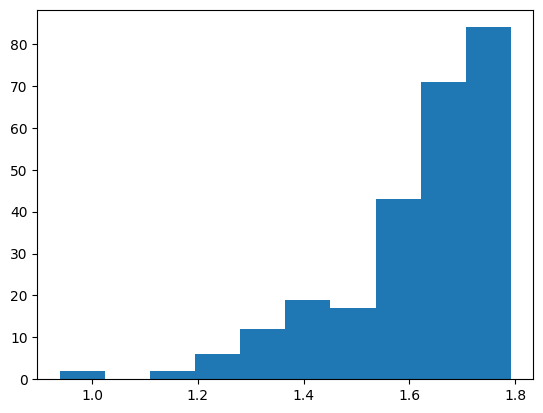

In [26]:
plt.hist(dist.entropy())

In [27]:
use_targets = False

timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=remove_targets(timesteps.grid),
        goal=remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

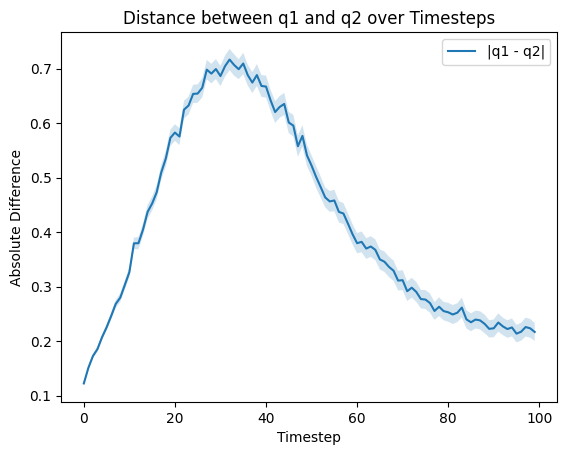

In [28]:
plot_q_value_difference(agent, tr_states, tr_goals, tr_actions, EPISODE_LENGTH, NUM_ENVS)

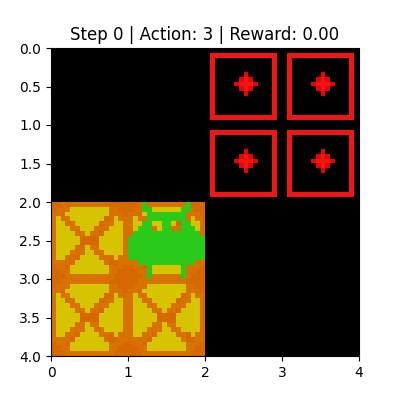

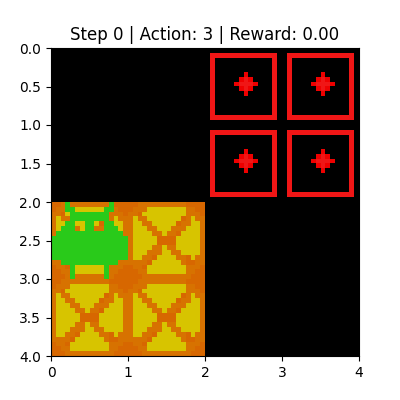

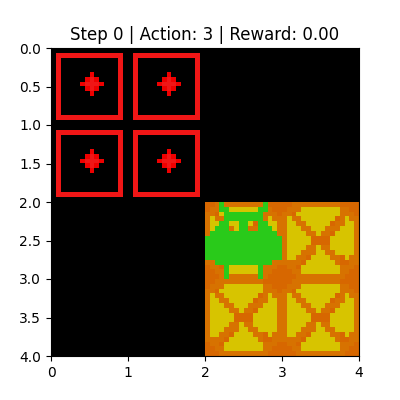

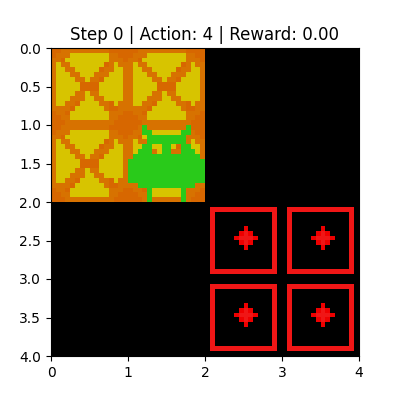

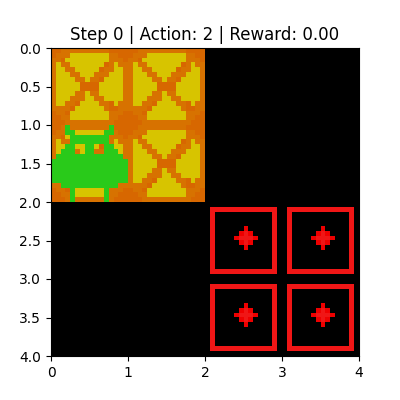

In [29]:
for idx in range(5):
    display_gif(env, timesteps, idx)
